In [32]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
# Load pyNA
pyna_settings = pyna.load_settings(case_name='stca')
py = pyna(settings=pyna_settings)
ac = py.ac
py.settings.engine_file_name = 'engine_deck_stca.csv'
py.engine.load_deck(settings=py.settings)
engine = py.engine

In [34]:
# Inputs
pi_ref = 1e-12
rho_0 = 1.225
c_0 = np.sqrt(288.15*1.4*287)
M_0 = 128.6/c_0
z = 0

### Flaps

In [35]:
# Inputs 
theta_flaps_lst = np.linspace(1, 26, 26)

In [38]:
# Flaps 
pi_star_flaps = np.zeros(np.size(theta_flaps_lst))
pwl_flaps = np.zeros(np.size(theta_flaps_lst))
dpwl_dflaps = np.zeros(np.size(theta_flaps_lst))

for i, theta_flaps in enumerate(theta_flaps_lst):
    pi_star_flaps[i] = 2.787e-4 * M_0 ** 6 * ac.af_S_f / ac.af_b_w ** 2 * np.sin(theta_flaps * np.pi / 180.) ** 2
    pwl_flaps[i] = 10*np.log10(pi_star_flaps[i]) +  10*np.log10(rho_0*c_0**3*ac.af_b_w**2/pi_ref)
    dpwl_dflaps[i] = 1/pi_star_flaps[i]/np.log(10) * 2.787e-4 * M_0 ** 6 * ac.af_S_f / ac.af_b_w ** 2 * 2 * np.sin(theta_flaps * np.pi / 180.) * np.cos(theta_flaps * np.pi / 180.)

Text(0, 0.5, '$\\frac{\\partial PWL}{\\partial \\theta_{flaps}}\\ [\\frac{dB}{deg}]$')

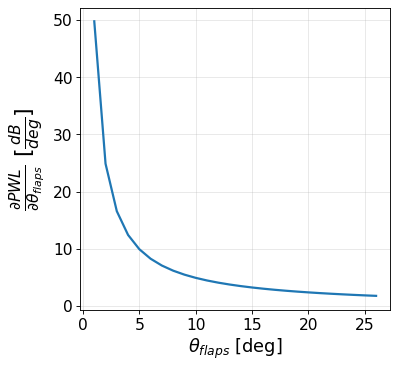

In [50]:
plt.figure(figsize=(5,5))
plt.style.use('../utils/plot.mplstyle')
plt.plot(theta_flaps_lst, dpwl_dflaps)
plt.xlabel(r'$\theta_{flaps}$ [deg]')
plt.ylabel(r'$\frac{\partial PWL}{\partial \theta_{flaps}}\ [\frac{dB}{deg}]$', fontsize=20)

### Jet mixing

In [51]:
from pyNA.src.engine import Engine
from pyNA.src.trajectory_src.propulsion import Propulsion

def jet_mixing_pi_star(engine, settings, TS, z, M_0, c_0, rho_0):
    
    engine_mode='noise'
    problem = om.Problem()
    problem.model.add_subsystem(name='propulsion',
                                subsys=Propulsion(vec_size=1, extrapolate=True, method='3D-lagrange3', settings=settings, engine=engine, engine_mode=engine_mode),
                                promotes_inputs=['z'],
                                promotes_outputs=[])
    problem.setup(force_alloc_complex=True)
    problem.set_val('propulsion.TS', TS)
    problem.set_val('propulsion.z', z)
    problem.set_val('propulsion.M_0', M_0)
    problem.run_model()
    
    rho_j_star = problem.get_val('propulsion.rho_j')/rho_0
    V_j_star = problem.get_val('propulsion.V_j')/c_0
    
    log10Vja0 = np.log10(V_j_star)
    if -0.45 < log10Vja0 < 0.25:
        array_1 = np.array([-0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
        array_2 = np.array([-1, -0.9, -0.76, -0.58, -0.41, -0.22, 0, 0.22, 0.5, 0.77, 1.07, 1.39, 1.74, 1.95, 2])
        omega = np.interp(log10Vja0, array_1, array_2)
    elif log10Vja0 >= 0.25:
        pdb.set_trace()
        omega = 2
    else:
        omega = np.NaN

    # Calculate power deviation factor (P)
    # Source: Zorumski report 1982 part 2. Chapter 8.4 Table III
    if -0.4 < log10Vja0 < 0.4:
        array_1 = np.array([-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,0.4])
        array_2 = np.array([-0.13, -0.13, -0.13, -0.13, -0.13, -0.12, -0.1, -0.05, 0, 0.1, 0.21, 0.32, 0.41, 0.43, 0.41,0.31, 0.14])
        log10P = np.interp(log10Vja0, array_1, array_2)
        P_function = 10 ** log10P
    else:
        P_function = np.NaN

    pi_star_jet = 6.67e-5 * rho_j_star**omega * V_j_star**8 * P_function

    return pi_star_jet

In [74]:
# Inputs
TS_lst = np.linspace(1, 1/26, 81)

In [75]:
# Jet mixing
pi_star_jet = np.zeros(np.size(TS_lst))
pwl_jet = np.zeros(np.size(TS_lst))
dpwl_dTS = np.zeros(np.size(TS_lst))

for i, TS in enumerate(TS_lst):

    n1 = 0.95
    n2 = 1.05
    
    pi_star_jet[i] = jet_mixing_pi_star(py.engine, py.settings, TS, z, M_0, c_0, rho_0)
    pwl_jet[i] = 10*np.log10(pi_star_jet[i]) + 10*np.log10(rho_0*c_0**3*ac.af_b_w**2/pi_ref)

    pi_99 = jet_mixing_pi_star(py.engine, py.settings, n1*TS, z, M_0, c_0, rho_0)
    pi101 = jet_mixing_pi_star(py.engine, py.settings, n2*TS, z, M_0, c_0, rho_0)
    pwl99 = 10*np.log10(pi_99) + 10*np.log10(rho_0*c_0**3*ac.af_b_w**2/pi_ref)
    pwl101 = 10*np.log10(pi101) + 10*np.log10(rho_0*c_0**3*ac.af_b_w**2/pi_ref)
    
    dpwl_dTS[i] = (pwl101-pwl99)/(n2*TS-n1*TS)

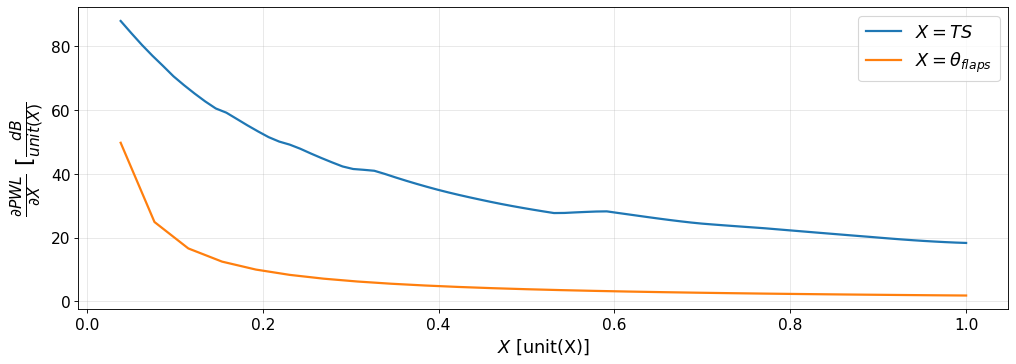

In [76]:
plt.figure(figsize=(15,5))
plt.style.use('../utils/plot.mplstyle')
plt.plot(TS_lst, dpwl_dTS, label='$X = TS$')
plt.plot(theta_flaps_lst/theta_flaps_lst[-1], dpwl_dflaps, label=r'$X = \theta_{flaps}$')
plt.xlabel(r'$X$ [unit(X)]')
plt.ylabel(r'$\frac{\partial PWL}{\partial X}\ [\frac{dB}{unit(X)}}]$', fontsize=20)
plt.legend(fontsize=16)